<a href="https://colab.research.google.com/github/ccorbett0116/Fall2025ResearchProject/blob/main/Research_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Title:
# Authors: Jose Henriquez, Cole Corbett
## Description:
The deployment of medical AI systems across different hospitals raises critical questions about whether fairness and representation quality can be reliably transferred across clinical domains. Models trained on one hospital’s imaging data are often reused in new environments where patient demographics, imaging devices, and diagnostic practices differ substantially, potentially resulting in unintended bias against certain groups. This project investigates this challenge by studying fairness-aware representation alignment in medical imaging. The student will train contrastive learning models—such as SimCLR—independently on two large-scale chest X-ray datasets: CheXpert (from Stanford Hospital) and MIMIC-CXR (from Beth Israel Deaconess Medical Center). After learning embeddings in each domain, the student will apply domain alignment techniques such as Procrustes alignment to map representations from the CheXpert embedding space into the MIMIC-CXR space. The aligned embeddings will then be evaluated using fairness metrics designed for representation spaces, including demographic subgroup alignment, intra- vs. inter-group embedding disparity, and cluster-level demographic parity. The expected outcome is a rigorous understanding of whether fairness properties learned in one hospital setting preserve, degrade, or improve when transferred to another, revealing how robust model fairness is to realworld clinical domain shifts. A practical use case involves a healthcare network seeking to deploy a model trained at a major academic hospital (e.g., Stanford) into a community hospital setting: this project helps determine whether the transferred representations remain equitable across patient groups such as older adults, women, or specific disease cohorts. The findings will support responsible AI deployment in healthcare by highlighting the conditions under which fairness is stable across institutions and identifying scenarios where domain-specific mitigation strategies may be required.

In [17]:
#Process is probably different on colab, this is hyperspecific to me because I'm working on Pycharm connected to my WSL
import sys
import os
!{sys.executable} -m pip install kagglehub polars numpy
#We're going to use polars because it's significantly faster, it's build on rust and enables multi-threaded processing as well as some memory optimizations over pandas.

# Install PyTorch with CUDA 13.0 support (LINUX Link (May work for windows??))
!{sys.executable} -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130

# Install PyTorch Lightning and Lightning Bolts for SimCLR
!{sys.executable} -m pip install pytorch-lightning lightning-bolts

# Install scipy, sklearn, umap and matplotlib for analysis
!{sys.executable} -m pip install scikit-learn matplotlib umap-learn scipy

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /home/coding/.virtualenvs/Fall2025ResearchProject/bin/python -m pip install --upgrade pip
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Looking in indexes: https://download.pytorch.org/whl/cu130

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /home/coding/.virtualenvs/Fall2025ResearchProject/bin/python -m pip install --upgrade pip
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /home/coding/.virtualenvs/Fall2025ResearchProject/bin/python -m pip install --upgrade pip
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /home/coding/.virtualenvs/Fall2025R

In [18]:
# Imports
import random
import numpy as np
from PIL import Image
import kagglehub
import polars as pol
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, silhouette_score, f1_score, pairwise_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
import matplotlib.pyplot as plt
import umap
from scipy.linalg import orthogonal_procrustes
from scipy.spatial.distance import pdist, squareform, euclidean

In [19]:
# Hyperparameters
base_model="resnet50"
max_epochs = 30
max_epochs_mimic = 60
proj_dim = 512 # How many dimensions to project the image into
base_lr = 1e-3
temperature = 0.5
batch_size = 128

num_workers = 12 # This one just effects cpu utilization/training time

In [20]:
# Download datasets
path_chexpert = kagglehub.dataset_download("mimsadiislam/chexpert")
print("Path to chexpert dataset files:", path_chexpert)

path_mimic = kagglehub.dataset_download("itsanmol124/mimic-cxr")
print("Path to mimic dataset files:", path_mimic)

Path to chexpert dataset files: /home/coding/.cache/kagglehub/datasets/mimsadiislam/chexpert/versions/1
Path to mimic dataset files: /home/coding/.cache/kagglehub/datasets/itsanmol124/mimic-cxr/versions/1


In [21]:
dir_chexpert = os.path.join(path_chexpert, "CheXpert-v1.0-small")
dir_mimic = path_mimic

train_csv_chexpert = os.path.join(dir_chexpert, "train.csv")
valid_csv_chexpert = os.path.join(dir_chexpert, "valid.csv")
full_csv_mimic = os.path.join(dir_mimic, "mimic-cxr.csv")

df_complete_mimic = pol.read_csv(full_csv_mimic)
df_train_chexpert = pol.read_csv(train_csv_chexpert)
df_valid_chexpert = pol.read_csv(valid_csv_chexpert)

df_train_mimic = df_complete_mimic.filter(pol.col("split") == "train")
df_valid_mimic = df_complete_mimic.filter(pol.col("split") == "valid")

In [22]:
df_train_mimic.head()

filename,split,label,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Lung Lesion,Lung Opacity,Normal,Pleural Effusion,Pneumonia,Pneumothorax
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""s50000014.jpg""","""train""","""Normal""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""s50000052.jpg""","""train""","""Normal""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""s50000125.jpg""","""train""","""Normal""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""s50000173.jpg""","""train""","""Normal""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""s50000198.jpg""","""train""","""Consolidation""",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df_train_chexpert.head()

Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
str,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""CheXpert-v1.0-small/train/pati…","""Female""",68,"""Frontal""","""AP""",1.0,null,null,null,null,null,null,null,null,0.0,null,null,null,1.0
"""CheXpert-v1.0-small/train/pati…","""Female""",87,"""Frontal""","""AP""",null,null,-1.0,1.0,null,-1.0,-1.0,null,-1.0,null,-1.0,null,1.0,null
"""CheXpert-v1.0-small/train/pati…","""Female""",83,"""Frontal""","""AP""",null,null,null,1.0,null,null,-1.0,null,null,null,null,null,1.0,null
"""CheXpert-v1.0-small/train/pati…","""Female""",83,"""Lateral""",null,null,null,null,1.0,null,null,-1.0,null,null,null,null,null,1.0,null
"""CheXpert-v1.0-small/train/pati…","""Male""",41,"""Frontal""","""AP""",null,null,null,null,null,1.0,null,null,null,0.0,null,null,null,null


In [24]:
# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")
print(f"Using device: {device}")

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA version: 13.0
Number of GPUs: 1
Current GPU: NVIDIA GeForce RTX 5080
Using device: cuda


In [25]:
print(dir_mimic+"/train")

/home/coding/.cache/kagglehub/datasets/itsanmol124/mimic-cxr/versions/1/train


In [26]:
# Use Tensor Cores efficiently on 5080
torch.set_float32_matmul_precision("high")

# -----------------------
# SimCLR augmentations
# -----------------------
simclr_transform = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(224, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply(
        [T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)],
        p=0.8,
    ),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    # CXRs are essentially grayscale; simple normalization is fine as a start
    T.Normalize(mean=[0.5], std=[0.5]),
])


# -----------------------
# Single-dataset SimCLR Dataset
# -----------------------
class SimCLRDataset(Dataset):
    """
    Unlabeled dataset for SimCLR: returns (view1, view2) per image.
    This handles ONE dataset (CheXpert OR MIMIC).
    """
    def __init__(self, df, root, path_col, transform=None, is_mimic=False):
        self.transform = transform
        self.is_mimic = is_mimic
        
        # df is a Polars DataFrame; df[path_col] is a Series → .to_list()
        rel_paths = df[path_col].to_list()
        
        self.paths = [os.path.join(root, p) for p in rel_paths]

        print(f"Total images for this SimCLR dataset: {len(self.paths)}")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is None:
            raise ValueError("SimCLRDataset requires a transform.")

        xi = self.transform(img)
        xj = self.transform(img)
        return xi, xj


# -----------------------
# Build DataLoaders
# -----------------------

simclr_train_chexpert = SimCLRDataset(
    df=df_train_chexpert,
    root=path_chexpert,
    path_col="Path",      # CheXpert image path column
    transform=simclr_transform,
    is_mimic=False,
)

simclr_train_loader_chexpert = DataLoader(
    simclr_train_chexpert,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

simclr_train_mimic = SimCLRDataset(
    df=df_train_mimic,
    root=dir_mimic+'/train',
    path_col="filename",     # MIMIC image path column
    transform=simclr_transform,
    is_mimic=True,        # Enable MIMIC path parsing
)

simclr_train_loader_mimic = DataLoader(
    simclr_train_mimic,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

Total images for this SimCLR dataset: 223414
Total images for this SimCLR dataset: 83837


In [27]:
class SimCLR(pl.LightningModule):
    def __init__(
        self,
        base_model: str = "resnet34",
        out_dim: int = 128,
        lr: float = 1e-3,
        temperature: float = 0.5,
    ):
        super().__init__()
        self.save_hyperparameters()

        # -------- Encoder (backbone) --------
        if base_model == "resnet34":
            backbone = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        elif base_model == "resnet50":
            backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        else:
            raise ValueError(f"Unsupported base_model: {base_model}")

        feat_dim = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.encoder = backbone

        # -------- Projection head --------
        self.projector = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim, out_dim),
        )

        self.temperature = temperature
        self.lr = lr

    def forward(self, x):
        h = self.encoder(x)           # [B, feat_dim]
        z = self.projector(h)         # [B, out_dim]
        z = F.normalize(z, dim=1)     # L2-normalize
        return z

    def nt_xent_loss(self, z_i, z_j):
        """
        NT-Xent (InfoNCE) loss used in SimCLR.
        z_i, z_j: [B, D] normalized embeddings for the two views
        """
        batch_size = z_i.size(0)
        z = torch.cat([z_i, z_j], dim=0)   # [2B, D]

        # Cosine similarity matrix: [2B, 2B]
        sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
        sim = sim / self.temperature

        # Mask out self-similarity on diagonal
        self_mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
        sim = sim.masked_fill(self_mask, float("-inf"))

        # Positive for each i is i+batch_size (wrap around)
        pos_indices = torch.arange(2 * batch_size, device=z.device)
        pos_indices = (pos_indices + batch_size) % (2 * batch_size)

        loss = F.cross_entropy(sim, pos_indices)
        return loss

    def training_step(self, batch, batch_idx):
        x_i, x_j = batch
        z_i = self(x_i)
        z_j = self(x_j)
        loss = self.nt_xent_loss(z_i, z_j)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.trainer.max_epochs
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [28]:
lr_monitor = LearningRateMonitor(logging_interval="epoch")

# -----------------------
# Loggers
# -----------------------

tb_logger_chexpert = TensorBoardLogger(
    save_dir="tb_logs",
    name="simclr_chexpert"
)

tb_logger_mimic = TensorBoardLogger(
    save_dir="tb_logs",
    name="simclr_mimic"
)

# -----------------------
# CheXpert SimCLR
# -----------------------
simclr_chexpert = SimCLR(
    base_model=base_model,
    out_dim=proj_dim,
    lr=base_lr,
    temperature=temperature,
)

ckpt_chexpert = ModelCheckpoint(
    dirpath="checkpoints/simclr_chexpert",
    filename="simclr-chexpert-{epoch:02d}-{train_loss:.4f}",
    save_top_k=3,
    monitor="train_loss",
    mode="min",
    save_last=True,
)

trainer_chexpert = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu" if torch.cuda.is_available() else "auto",
    devices=1,
    precision="bf16" if torch.cuda.is_available() else "32",
    callbacks=[ckpt_chexpert, lr_monitor],
    logger=tb_logger_chexpert,
    log_every_n_steps=50,
)


# -----------------------
# MIMIC SimCLR
# -----------------------
simclr_mimic = SimCLR(
    base_model=base_model,
    out_dim=proj_dim,
    lr=base_lr,
    temperature=temperature,
)

ckpt_mimic = ModelCheckpoint(
    dirpath="checkpoints/simclr_mimic",
    filename="simclr-mimic-{epoch:02d}-{train_loss:.4f}",
    save_top_k=3,
    monitor="train_loss",
    mode="min",
    save_last=True,
)

trainer_mimic = pl.Trainer(
    max_epochs=max_epochs_mimic,
    accelerator="gpu" if torch.cuda.is_available() else "auto",
    devices=1,
    precision="bf16" if torch.cuda.is_available() else "32",
    callbacks=[ckpt_mimic, lr_monitor],
    logger=tb_logger_mimic,
    log_every_n_steps=50,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
# print("=== Training SimCLR on CheXpert ===")
# trainer_chexpert.fit(simclr_chexpert, simclr_train_loader_chexpert)

In [30]:
#print("=== Training SimCLR on MIMIC ===")
#trainer_mimic.fit(simclr_mimic, simclr_train_loader_mimic)

In [31]:
# Load trained SimCLR models
simclr_chexpert = SimCLR.load_from_checkpoint("./checkpoints/simclr_chexpert/last-v1.ckpt")
simclr_mimic = SimCLR.load_from_checkpoint("./checkpoints/simclr_mimic/last-v1.ckpt")

simclr_chexpert.eval().cuda()
simclr_mimic.eval().cuda()


SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [32]:
# ===============================
# Validation Transform (NO AUGS)
# ===============================
val_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])


# ===============================
# Validation Datasets
# ===============================
chexpert_val_ds = SimCLRDataset(
    df=df_valid_chexpert,
    root=path_chexpert,
    path_col="Path",
    transform=val_transform,
)

mimic_val_ds = SimCLRDataset(
    df=df_valid_mimic,
    root=path_mimic + "/valid",
    path_col="filename",
    transform=val_transform,
)


# ===============================
# Validation DataLoaders
# ===============================
chexpert_val_loader = DataLoader(
    chexpert_val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0,
)

mimic_val_loader = DataLoader(
    mimic_val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0,
)


# ===============================
# Embedding Extraction Function
# ===============================
def extract_embeddings(model, loader):
    model.eval()
    
    model = model.to("cuda" if torch.cuda.is_available() else "cpu")

    all_embeds = []
    with torch.no_grad():
        for (x_i, _) in loader:  # only need one view
            x_i = x_i.to(model.device)
            z = model(x_i)
            all_embeds.append(z.cpu())

    return torch.cat(all_embeds, dim=0)


# ===============================
# Extract Embeddings
# ===============================
emb_chexpert = extract_embeddings(simclr_chexpert, chexpert_val_loader)
emb_mimic   = extract_embeddings(simclr_mimic, mimic_val_loader)

print("CheXpert embeddings:", emb_chexpert.shape)
print("MIMIC embeddings:", emb_mimic.shape)

Total images for this SimCLR dataset: 234
Total images for this SimCLR dataset: 711
CheXpert embeddings: torch.Size([234, 512])
MIMIC embeddings: torch.Size([711, 512])


In [33]:
torch.save(emb_chexpert, "emb_chexpert.pt")
torch.save(emb_mimic, "emb_mimic.pt")

# Embedding Quality Checks (Polars-based)

We perform three types of embedding quality checks for CheXpert and MIMIC:

1. **Embedding Distribution**  
   - Compute per-dimension mean and variance
   - Compute row-wise Euclidean norms
   - Check that embeddings are not collapsed and have similar scales

2. **Nearest Neighbor Consistency**  
   - Compute pairwise distances within each domain
   - Check that nearest neighbors have the same disease labels
   - Optionally, check demographic leakage

3. **UMAP Visualization**  
   - Reduce embeddings to 2D
   - Color by dataset, disease, or demographic
   - Verify that alignment preserves disease clusters and reduces domain gap


In [34]:
# Convert embeddings to numpy
emb_chex_np = emb_chexpert.cpu().numpy()
emb_mimic_np = emb_mimic.cpu().numpy()

# Convert to Polars DataFrame
df_emb_chex = pol.DataFrame([list(row) for row in emb_chex_np], schema=[f"dim_{i}" for i in range(emb_chex_np.shape[1])])
df_emb_mimic = pol.DataFrame([list(row) for row in emb_mimic_np], schema=[f"dim_{i}" for i in range(emb_mimic_np.shape[1])])

# Per-dimension mean and variance
stats_chex = df_emb_chex.select([
    pol.col(c).mean().alias(f"{c}_mean") for c in df_emb_chex.columns
] + [
    pol.col(c).var().alias(f"{c}_var") for c in df_emb_chex.columns
])

# Row-wise Euclidean norms in Polars
df_emb_chex = df_emb_chex.with_columns(
    pol.sum_horizontal([pol.col(c)**2 for c in df_emb_chex.columns]).sqrt().alias("norm")
)

# Per-dimension mean and variance
stats_mimic = df_emb_mimic.select([
    pol.col(c).mean().alias(f"{c}_mean") for c in df_emb_mimic.columns
] + [
    pol.col(c).var().alias(f"{c}_var") for c in df_emb_mimic.columns
])

# Row-wise Euclidean norms in Polars
df_emb_mimic = df_emb_mimic.with_columns(
    pol.sum_horizontal([pol.col(c)**2 for c in df_emb_mimic.columns]).sqrt().alias("norm")
)

/tmp/ipykernel_119514/1972022444.py:6: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df_emb_chex = pol.DataFrame([list(row) for row in emb_chex_np], schema=[f"dim_{i}" for i in range(emb_chex_np.shape[1])])
/tmp/ipykernel_119514/1972022444.py:7: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df_emb_mimic = pol.DataFrame([list(row) for row in emb_mimic_np], schema=[f"dim_{i}" for i in range(emb_mimic_np.shape[1])])


In [35]:
# Display first few rows of stats
stats_chex.head()  # shows mean/variance per dimension
stats_mimic.head()

# Show the distribution of norms
df_emb_chex.select("norm").describe()  # min, max, mean, std
df_emb_mimic.select("norm").describe()


statistic,norm
str,f64
"""count""",711.0
"""null_count""",0.0
"""mean""",1.0
"""std""",3.1272e-8
"""min""",1.0
"""25%""",1.0
"""50%""",1.0
"""75%""",1.0
"""max""",1.0


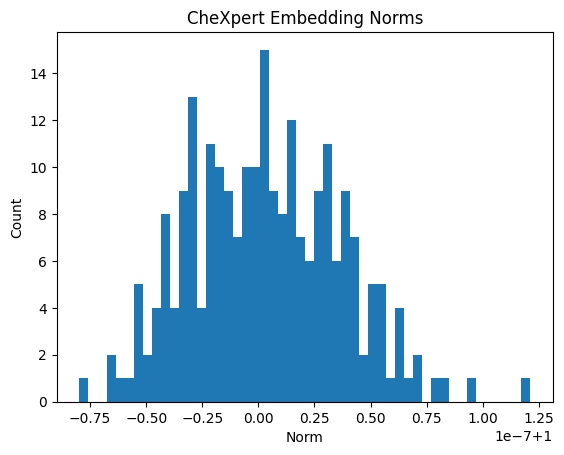

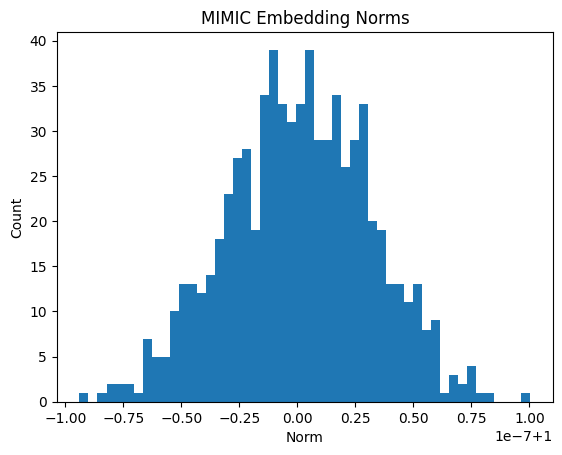

In [36]:
# Optional: plot histogram of norms

plt.hist(df_emb_chex["norm"].to_numpy(), bins=50)
plt.title("CheXpert Embedding Norms")
plt.xlabel("Norm")
plt.ylabel("Count")
plt.show()

plt.hist(df_emb_mimic["norm"].to_numpy(), bins=50)
plt.title("MIMIC Embedding Norms")
plt.xlabel("Norm")
plt.ylabel("Count")
plt.show()


In [37]:
disease_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Lung Lesion", "Lung Opacity",
    "Pleural Effusion", "Pneumonia", "Pneumothorax"
]

df_demo_chex = df_valid_chexpert.select(["Sex", "Age"] + disease_columns)


# Pairwise cosine distances
dist_matrix = pairwise_distances(emb_chex_np, metric="cosine")

# Top-k neighbors (exclude self)
k = 5
neighbors_idx = np.argsort(dist_matrix, axis=1)[:, 1:k+1]




In [38]:
# Check neighbors of first 5 embeddings
for i in range(5):
    print("Embedding", i, "neighbors:", neighbors_idx[i])

# Example: fraction of neighbors sharing the same disease
k = 5
same_disease_fraction = []
for i in range(len(neighbors_idx)):
    neighbors = neighbors_idx[i]
    # Compare with i-th sample
    fraction = (df_demo_chex["Atelectasis"].to_numpy()[neighbors] == df_demo_chex["Cardiomegaly"].to_numpy()[i]).mean()
    same_disease_fraction.append(fraction)

print("Mean fraction of neighbors sharing Atelectasis:", np.mean(same_disease_fraction))


Embedding 0 neighbors: [120  32  90 230 178]
Embedding 1 neighbors: [97  8 35  7 71]
Embedding 2 neighbors: [36 72 77 98 53]
Embedding 3 neighbors: [229 196 206 204 218]
Embedding 4 neighbors: [177 138  68  29 224]
Mean fraction of neighbors sharing Atelectasis: 0.6282051282051282


In [39]:
# Concatenate embeddings
emb_all = np.vstack([emb_chex_np, emb_mimic_np])
labels = ["CheXpert"] * len(emb_chex_np) + ["MIMIC"] * len(emb_mimic_np)

# UMAP projection
reducer = umap.UMAP(n_components=2, random_state=42)
emb_2d = reducer.fit_transform(emb_all)

# Create Polars DataFrame for plotting
df_umap = pol.DataFrame({
    "x": emb_2d[:,0],
    "y": emb_2d[:,1],
    "dataset": labels
})

/home/coding/.virtualenvs/Fall2025ResearchProject/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


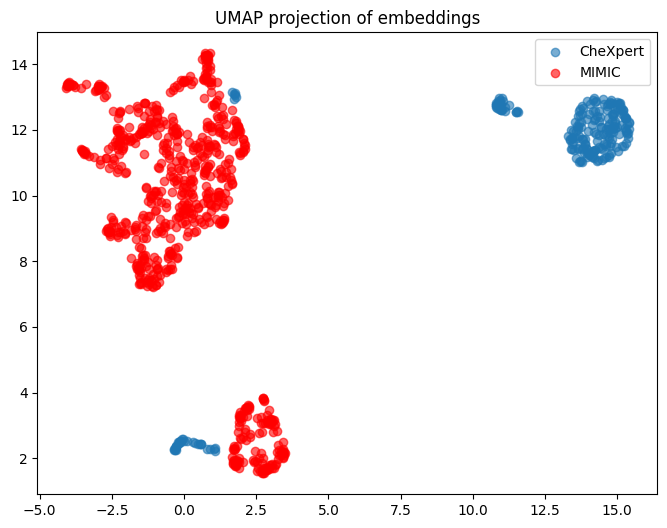

In [40]:
# Simple 2D scatter colored by dataset
plt.figure(figsize=(8,6))
plt.scatter(df_umap.filter(pol.col("dataset") == "CheXpert")["x"].to_numpy(),
            df_umap.filter(pol.col("dataset") == "CheXpert")["y"].to_numpy(),
            alpha=0.6, label="CheXpert")
plt.scatter(df_umap.filter(pol.col("dataset") == "MIMIC")["x"].to_numpy(),
            df_umap.filter(pol.col("dataset") == "MIMIC")["y"].to_numpy(),
            alpha=0.6, label="MIMIC", color="red")
plt.legend()
plt.title("UMAP projection of embeddings")
plt.show()


In [200]:
# Convert embeddings to numpy for easier manipulation
emb_chex_np = emb_chexpert.cpu().numpy()

# Define disease columns
disease_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Lung Lesion", "Lung Opacity",
    "Pleural Effusion", "Pneumonia", "Pneumothorax"
]

# Select demographics AND disease columns from CheXpert
df_demo_chex = df_valid_chexpert.select(["Sex", "Age"] + disease_columns)

# Create age grouping columns
df_demo_chex = df_demo_chex.with_columns([
    pol.when(pol.col("Age") <= 30).then(pol.lit("0-30"))
      .when(pol.col("Age") <= 60).then(pol.lit("31-60"))
      .otherwise(pol.lit("61+"))
      .alias("Age_Group3"),
    pol.when(pol.col("Age") <= 30).then(pol.lit("0-30"))
      .when(pol.col("Age") <= 60).then(pol.lit("31-60"))
      .otherwise(pol.lit("61+"))
      .alias("Age_Group")
])

# Quick check
print("Embeddings shape:", emb_chex_np.shape)
print("Demographics shape:", df_demo_chex.shape)
df_demo_chex.head()

Embeddings shape: (234, 512)
Demographics shape: (234, 14)


Sex,Age,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Lung Lesion,Lung Opacity,Pleural Effusion,Pneumonia,Pneumothorax,Age_Group3,Age_Group
str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""Male""",73,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,"""61+""","""61+"""
"""Male""",70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""61+""","""61+"""
"""Male""",70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""61+""","""61+"""
"""Male""",85,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,"""61+""","""61+"""
"""Female""",42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""31-60""","""31-60"""


# Representation Group Shift (Centroid Distance)

**Goal:**
Evaluate whether the learned CheXpert **embedding space itself** encodes demographic information (e.g., sex or age), indicating *representation-level bias*.

**Steps:**
1. Select a demographic variable (e.g., `Sex`, `Age_Group3`).
2. Split the embeddings into subgroups based on this variable.
3. Compute the **mean embedding vector** (centroid) for each subgroup.
4. Compute **pairwise distances** between subgroup centroids
   using Euclidean distance (or cosine distance).
5. Interpretation:
   - **Small centroid distances** → demographic groups occupy similar regions of the embedding space → lower representation bias.
   - **Large centroid distances** → embeddings encode demographic differences → potential representation bias or shortc

In [224]:
import numpy as np
from scipy.spatial.distance import euclidean, pdist, squareform

def compute_representation_shift(
    df,
    embeddings,
    demographic_col,
    disease_columns,
    distance_metric="euclidean",
    return_matrix=False
):
    """
    Compute representation shift between demographic groups for each disease.
    
    Representation shift is defined as the distance between group centroids
    (mean embeddings) among samples positive for each disease.
    
    Parameters
    ----------
    df : polars.DataFrame
        DataFrame containing demographic and disease labels
    embeddings : np.ndarray
        Embedding matrix with shape (n_samples, n_features)
    demographic_col : str
        Name of the demographic column to group by
    disease_columns : list of str
        List of disease column names (binary labels)
    distance_metric : str, default="euclidean"
        Distance metric to use
    return_matrix : bool, default=False
        If True, returns full pairwise distance matrix for groups with 3+.
        If False, returns single distance for exactly 2 groups.
    
    Returns
    -------
    dict
        If return_matrix=False: maps disease -> distance (or NaN)
        If return_matrix=True: maps disease -> (valid_groups, distance_matrix) or None
    

    """
    # Get unique groups
    groups = df[demographic_col].unique().to_list()
    
    rep_shift = {}
    
    for disease in disease_columns:
        group_means = []
        valid_groups = []
        
        for g in groups:
            # Create mask for this group and disease-positive samples
            mask = (df[demographic_col] == g) & (df[disease] == 1)
            emb_group = embeddings[mask.to_numpy()]
            
            if emb_group.shape[0] > 0:
                group_means.append(emb_group.mean(axis=0))
                valid_groups.append(g)
            else:
                group_means.append(None)
        
        # Filter to only valid groups
        filtered_means = [m for m in group_means if m is not None]
        
        if return_matrix:
            # Multi-group case: return distance matrix
            if len(filtered_means) >= 2:
                mean_matrix = np.stack(filtered_means)
                dist_matrix = squareform(pdist(mean_matrix, metric=distance_metric))
                rep_shift[disease] = (valid_groups, dist_matrix)
            else:
                rep_shift[disease] = None
        else:
            # Binary case: return single distance
            if len(filtered_means) == 2:
                if distance_metric == "euclidean":
                    rep_shift[disease] = euclidean(filtered_means[0], filtered_means[1])
                else:
                    raise ValueError(f"Unsupported distance metric: {distance_metric}")
            else:
                rep_shift[disease] = float("nan")
    
    return rep_shift

In [225]:
# Usage for binary groups (Sex):
rep_shift = compute_representation_shift(
    df=df_demo_chex,
    embeddings=emb_chex_np,
    demographic_col="Sex",
    disease_columns=disease_columns
)

print("Representation Sex-Shift (centroid distance among positives):")
for disease, dist in rep_shift.items():
    print(f"{disease}: {dist}")

Representation Sex-Shift (centroid distance among positives):
Atelectasis: 0.31700628995895386
Cardiomegaly: 0.3071540296077728
Consolidation: 0.3946182429790497
Edema: 0.35955893993377686
Enlarged Cardiomediastinum: 0.27529600262641907
Lung Lesion: nan
Lung Opacity: 0.2959432303905487
Pleural Effusion: 0.3945768475532532
Pneumonia: 0.8418067693710327
Pneumothorax: 0.8851691484451294


In [226]:
# Usage for multiple groups (Age):
age_rep_shift = compute_representation_shift(
    df=df_demo_chex,
    embeddings=emb_chex_np,
    demographic_col="Age_Group3",
    disease_columns=disease_columns,
    return_matrix=True
)

print("\nRepresentation Age-Shift (centroid distances among positives):\n")
for disease, result in age_rep_shift.items():
    print("Disease:", disease)
    if result is None:
        print("  Not enough cases in any age group\n")
    else:
        groups, matrix = result
        print("  Age Groups:", groups)
        print("  Pairwise centroid distances:")
        print(matrix, "\n")


Representation Age-Shift (centroid distances among positives):

Disease: Atelectasis
  Age Groups: ['61+', '0-30', '31-60']
  Pairwise centroid distances:
[[0.         0.61636039 0.26393404]
 [0.61636039 0.         0.64734192]
 [0.26393404 0.64734192 0.        ]] 

Disease: Cardiomegaly
  Age Groups: ['61+', '0-30', '31-60']
  Pairwise centroid distances:
[[0.         0.75072829 0.34113075]
 [0.75072829 0.         0.70399368]
 [0.34113075 0.70399368 0.        ]] 

Disease: Consolidation
  Age Groups: ['61+', '0-30', '31-60']
  Pairwise centroid distances:
[[0.         0.98525779 0.44989273]
 [0.98525779 0.         1.03849391]
 [0.44989273 1.03849391 0.        ]] 

Disease: Edema
  Age Groups: ['61+', '0-30', '31-60']
  Pairwise centroid distances:
[[0.         0.77591246 0.37067375]
 [0.77591246 0.         0.73242434]
 [0.37067375 0.73242434 0.        ]] 

Disease: Enlarged Cardiomediastinum
  Age Groups: ['61+', '0-30', '31-60']
  Pairwise centroid distances:
[[0.         0.74887387 

# Representation Group Shift Within Disease Positives (Age Groups)

We evaluate **representation-level fairness** by measuring how similarly the
embedding space represents different demographic groups *within each disease*.

This is **not** prediction-based Equalized Odds.
Instead, it measures how much the embedding geometry separates demographic
groups when conditioned on a disease label.

---

## Method

For each disease:

1. Restrict the dataset to **positive cases** (label = 1).
2. Split these embeddings by the demographic group (e.g., `Age_Group`).
3. Compute the **mean embedding vector** (centroid) for each group.
4. Compute **pairwise Euclidean distances** between group centroids.
5. Interpret distances as representation-level demographic separation.

---

## Interpretation

- **Small centroid distances**
  → Demographic groups with the same disease occupy similar regions
     of the embedding space → lower representation bias.

- **Large centroid distances**
  → Embeddings separate groups strongly → potential representation bias
     or demographic shortcut learning.

---

## Important Note

These centroid distances evaluate **fairness in the embedding space**
(i.e., how the model *represents* different groups).
They are **not Equalized Odds**, which requires classifier predictions.

Use this metric to assess whether the embedding itself encodes demographic
information in a way that may affect fairness of downstream tasks.


In [203]:
def knn_demographic_clustering(emb, demo_array, k=10, metric="euclidean"):
    """
    Compute kNN demographic clustering statistics for an embedding space.

    Parameters
    ----------
    emb : np.ndarray, shape (N, d)
        Embedding matrix.
    demo_array : np.ndarray, shape (N,)
        Demographic labels (e.g., Sex, Age_Group3).
    k : int
        Number of neighbors to use.
    metric : str
        Distance metric for kNN (default: euclidean).

    Returns
    -------
    global_mean : float
        Fraction of neighbors that share the same demographic group, averaged over all samples.
    per_group_means : dict
        Mapping group → average same-group neighbor fraction.
    same_group_fraction : np.ndarray, shape (N,)
        Per-sample fraction of same-group neighbors.
    """

    demo_array = np.asarray(demo_array)
    N = emb.shape[0]

    # Fit kNN (k+1 because nearest neighbor includes the sample itself)
    nn = NearestNeighbors(n_neighbors=k+1, metric=metric)
    nn.fit(emb)

    # Get neighbor indices (including self)
    distances, indices = nn.kneighbors(emb)

    # Remove self-neighbor (index 0)
    neighbor_idx = indices[:, 1:]  # shape (N, k)

    # Compute same-group counts
    same_group_counts = (demo_array[neighbor_idx] == demo_array[:, None]).sum(axis=1)
    same_group_fraction = same_group_counts / k

    # Global average homophily
    global_mean = same_group_fraction.mean()

    # Per-group averages
    unique_groups = np.unique(demo_array)
    per_group_means = {}
    for g in unique_groups:
        mask = (demo_array == g)
        per_group_means[g] = same_group_fraction[mask].mean()

    return global_mean, per_group_means, same_group_fraction

In [204]:
emb = emb_chex_np  # (N, d)
demo_arr = df_demo_chex["Sex"].to_numpy()

global_mean, per_group, fractions = knn_demographic_clustering(
    emb,
    demo_arr,
    k=10
)

print(f"Global same-group fraction: {global_mean:.3f}")
print("Per-group fractions:")
for g, v in per_group.items():
    print(f"  {g}: {v:.3f}")


Global same-group fraction: 0.570
Per-group fractions:
  Female: 0.497
  Male: 0.630


In [205]:
# kNN Demographic Stability Report (Age_Group)

age_arr = df_demo_chex["Age_Group"].to_numpy()
k_values = [5, 10, 20, 30, 50]

print("kNN Demographic Stability Report (Age_Group):\n")

for k in k_values:
    global_mean, per_group, _ = knn_demographic_clustering(
        emb_chex_np,
        age_arr,
        k=k
    )
    print(f"k = {k}")
    print(f"  Global same-group fraction: {global_mean:.3f}")
    for g, v in per_group.items():
        print(f"    {g}: {v:.3f}")
    print()


kNN Demographic Stability Report (Age_Group):

k = 5
  Global same-group fraction: 0.521
    0-30: 0.309
    31-60: 0.428
    61+: 0.624

k = 10
  Global same-group fraction: 0.510
    0-30: 0.241
    31-60: 0.426
    61+: 0.615

k = 20
  Global same-group fraction: 0.498
    0-30: 0.198
    31-60: 0.409
    61+: 0.613

k = 30
  Global same-group fraction: 0.488
    0-30: 0.162
    31-60: 0.402
    61+: 0.605

k = 50
  Global same-group fraction: 0.467
    0-30: 0.132
    31-60: 0.385
    61+: 0.583




## Procrustes Alignment - Stratified Approach

This cell performs **Procrustes alignment** to map CheXpert embeddings into MIMIC-CXR embedding space by finding an optimal rotation matrix. The two SimCLR models learned different "coordinate systems" for their embeddings, and Procrustes rotates one to match the other while preserving distances. We use the **stratified approach** because it samples equally from each disease category, ensuring that the alignment is guided by semantically matched pairs rather than random pairings. This creates a more accurate rotation matrix since we're explicitly teaching it that "pneumonia in CheXpert space should map to pneumonia in MIMIC space" for all 10 diseases, rather than hoping random samples happen to align well.

Stratified Procrustes Alignment by Disease
Atelectasis: 80 pairs
Cardiomegaly: 68 pairs
Consolidation: 22 pairs
Edema: 45 pairs
Enlarged Cardiomediastinum: 27 pairs
Lung Lesion: 1 pairs
Lung Opacity: 126 pairs
Pleural Effusion: 67 pairs
Pneumonia: 8 pairs
Pneumothorax: 8 pairs

Total pairs: 452
Running t-SNE on before-alignment embeddings...
Running t-SNE on after-alignment embeddings...


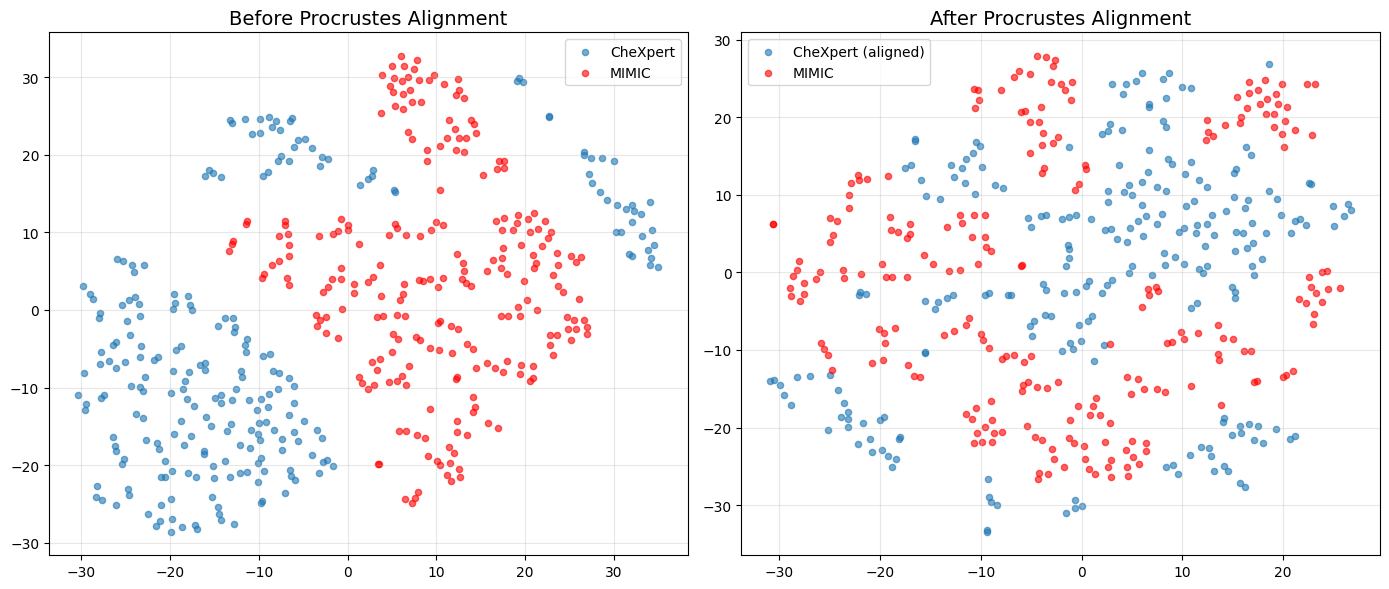


Aligned embeddings saved!


In [31]:
# =========================================
# Stratified Procrustes Alignment
# =========================================
disease_columns = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
    'Enlarged Cardiomediastinum', 'Lung Lesion', 'Lung Opacity',
    'Pleural Effusion', 'Pneumonia', 'Pneumothorax'
]

# =========================================
# Stratified Sampling Across Diseases
# =========================================
def procrustes_stratified(emb_source, emb_target,
                         labels_source, labels_target,
                         disease_columns, samples_per_disease=100):
    """
    Sample pairs from each disease category for balanced alignment.
    Ensures all diseases contribute to the alignment.
    """
    all_pairs_source = []
    all_pairs_target = []

    for disease in disease_columns:
        # Get positive samples for this disease
        mask_src = labels_source[disease] == 1
        mask_tgt = labels_target[disease] == 1

        indices_src = np.where(mask_src)[0]
        indices_tgt = np.where(mask_tgt)[0]

        if len(indices_src) == 0 or len(indices_tgt) == 0:
            print(f"Skipping {disease}: insufficient samples")
            continue

        # Sample pairs
        n_samples = min(len(indices_src), len(indices_tgt), samples_per_disease)
        sampled_src = np.random.choice(indices_src, n_samples, replace=False)
        sampled_tgt = np.random.choice(indices_tgt, n_samples, replace=False)

        all_pairs_source.extend(sampled_src)
        all_pairs_target.extend(sampled_tgt)

        print(f"{disease}: {n_samples} pairs")

    print(f"\nTotal pairs: {len(all_pairs_source)}")

    # Get paired embeddings
    X = emb_source[all_pairs_source].cpu().numpy()
    Y = emb_target[all_pairs_target].cpu().numpy()

    # Center and align
    X_mean = X.mean(axis=0)
    Y_mean = Y.mean(axis=0)
    X_centered = X - X_mean
    Y_centered = Y - Y_mean

    R, scale = orthogonal_procrustes(X_centered, Y_centered)

    # Apply to ALL source embeddings
    X_all = emb_source.cpu().numpy()
    X_all_centered = X_all - X_mean
    X_all_aligned = X_all_centered @ R + Y_mean

    return X_all_aligned, R, X_mean, Y_mean, all_pairs_source, all_pairs_target


# =========================================
# VISUALIZATION FUNCTION
# =========================================
def visualize_alignment(emb_before_source, emb_before_target,
                       emb_after_source, emb_after_target,
                       n_samples=1000, perplexity=30):
    """
    Visualize embeddings before and after alignment using t-SNE.
    """
    # Sample for visualization (t-SNE is slow on large datasets)
    n_viz = min(n_samples, len(emb_before_source), len(emb_before_target))

    idx_src = np.random.choice(len(emb_before_source), n_viz, replace=False)
    idx_tgt = np.random.choice(len(emb_before_target), n_viz, replace=False)

    # Before alignment
    emb_before = np.vstack([
        emb_before_source[idx_src],
        emb_before_target[idx_tgt]
    ])

    # After alignment
    emb_after = np.vstack([
        emb_after_source[idx_src],
        emb_after_target[idx_tgt]
    ])

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

    print("Running t-SNE on before-alignment embeddings...")
    emb_2d_before = tsne.fit_transform(emb_before)

    print("Running t-SNE on after-alignment embeddings...")
    emb_2d_after = tsne.fit_transform(emb_after)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Before
    ax1.scatter(emb_2d_before[:n_viz, 0], emb_2d_before[:n_viz, 1],
               label="CheXpert", alpha=0.6, s=20)
    ax1.scatter(emb_2d_before[n_viz:, 0], emb_2d_before[n_viz:, 1],
               label="MIMIC", alpha=0.6, s=20, color="red")
    ax1.set_title("Before Procrustes Alignment", fontsize=14)
    ax1.legend()
    ax1.grid(alpha=0.3)

    # After
    ax2.scatter(emb_2d_after[:n_viz, 0], emb_2d_after[:n_viz, 1],
               label="CheXpert (aligned)", alpha=0.6, s=20)
    ax2.scatter(emb_2d_after[n_viz:, 0], emb_2d_after[n_viz:, 1],
               label="MIMIC", alpha=0.6, s=20, color="red")
    ax2.set_title("After Procrustes Alignment", fontsize=14)
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


# =========================================
# EXECUTE STRATIFIED ALIGNMENT
# =========================================
print("=" * 60)
print("Stratified Procrustes Alignment by Disease")
print("=" * 60)

emb_aligned, R, mean_src, mean_tgt, pairs_src, pairs_tgt = procrustes_stratified(
    emb_chexpert, emb_mimic,
    df_valid_chexpert, df_valid_mimic,
    disease_columns,
    samples_per_disease=200
)

visualize_alignment(
    emb_chexpert.cpu().numpy(), emb_mimic.cpu().numpy(),
    emb_aligned, emb_mimic.cpu().numpy(),
    n_samples=1000
)

# =========================================
# SAVE ALIGNED EMBEDDINGS
# =========================================
torch.save(torch.from_numpy(emb_aligned), "emb_chexpert_aligned_stratified.pt")
torch.save({
    'rotation_matrix': R,
    'source_mean': mean_src,
    'target_mean': mean_tgt,
    'method': 'stratified',
    'pairs_source': pairs_src,
    'pairs_target': pairs_tgt
}, "procrustes_transform_stratified.pt")

print("\nAligned embeddings saved!")

In [32]:
print("CheXpert columns:", df_valid_chexpert.columns)
print("MIMIC columns:", df_valid_mimic.columns)

CheXpert columns: ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
MIMIC columns: ['filename', 'split', 'label', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Lung Lesion', 'Lung Opacity', 'Normal', 'Pleural Effusion', 'Pneumonia', 'Pneumothorax']


# Summary of Embedding Evaluation Tests

| Test | What it Measures | Why it is Relevant | Typical Expectations / Notes |
|------|-----------------|-----------------|-----------------------------|
| **t-SNE / UMAP** | Visual clustering of embeddings in 2D | Helps us see if images with similar features (or disease labels) naturally group together | Clusters should form for similar disease cases; overlapping clusters indicate embeddings are less discriminative |
| **Silhouette Score** | How well each point fits within its cluster | Quantifies clustering quality numerically | Score ranges from -1 to 1; closer to 1 = tight, well-separated clusters; negative = poor separation |
| **K-Nearest Neighbors (KNN)** | Classification accuracy using nearest neighbors in embedding space | Tests whether embeddings capture disease information that can predict labels | High accuracy (>70%) shows embeddings encode meaningful disease patterns; low accuracy suggests weak embeddings |
| **Cross-Dataset KNN** | KNN accuracy when training on one dataset and testing on another | Measures generalization of embeddings across datasets | High accuracy indicates good transferability; low accuracy indicates dataset-specific features dominate |
| **AUROC (Area Under ROC Curve)** | Ability of embeddings to rank positive vs. negative cases | Standard for binary classification performance; insensitive to class imbalance | Values range 0–1; 0.5 = random, >0.7 is reasonable, >0.9 is excellent. AUROC near 0.5 for cross-dataset means poor generalization |
| **PCA Explained Variance** | How much of the embedding variance is captured by the principal components | Helps identify dominant patterns in the embeddings and dimensionality reduction | Usually first 2–3 PCs capture meaningful variance; low variance explained may suggest complex or noisy embeddings |
